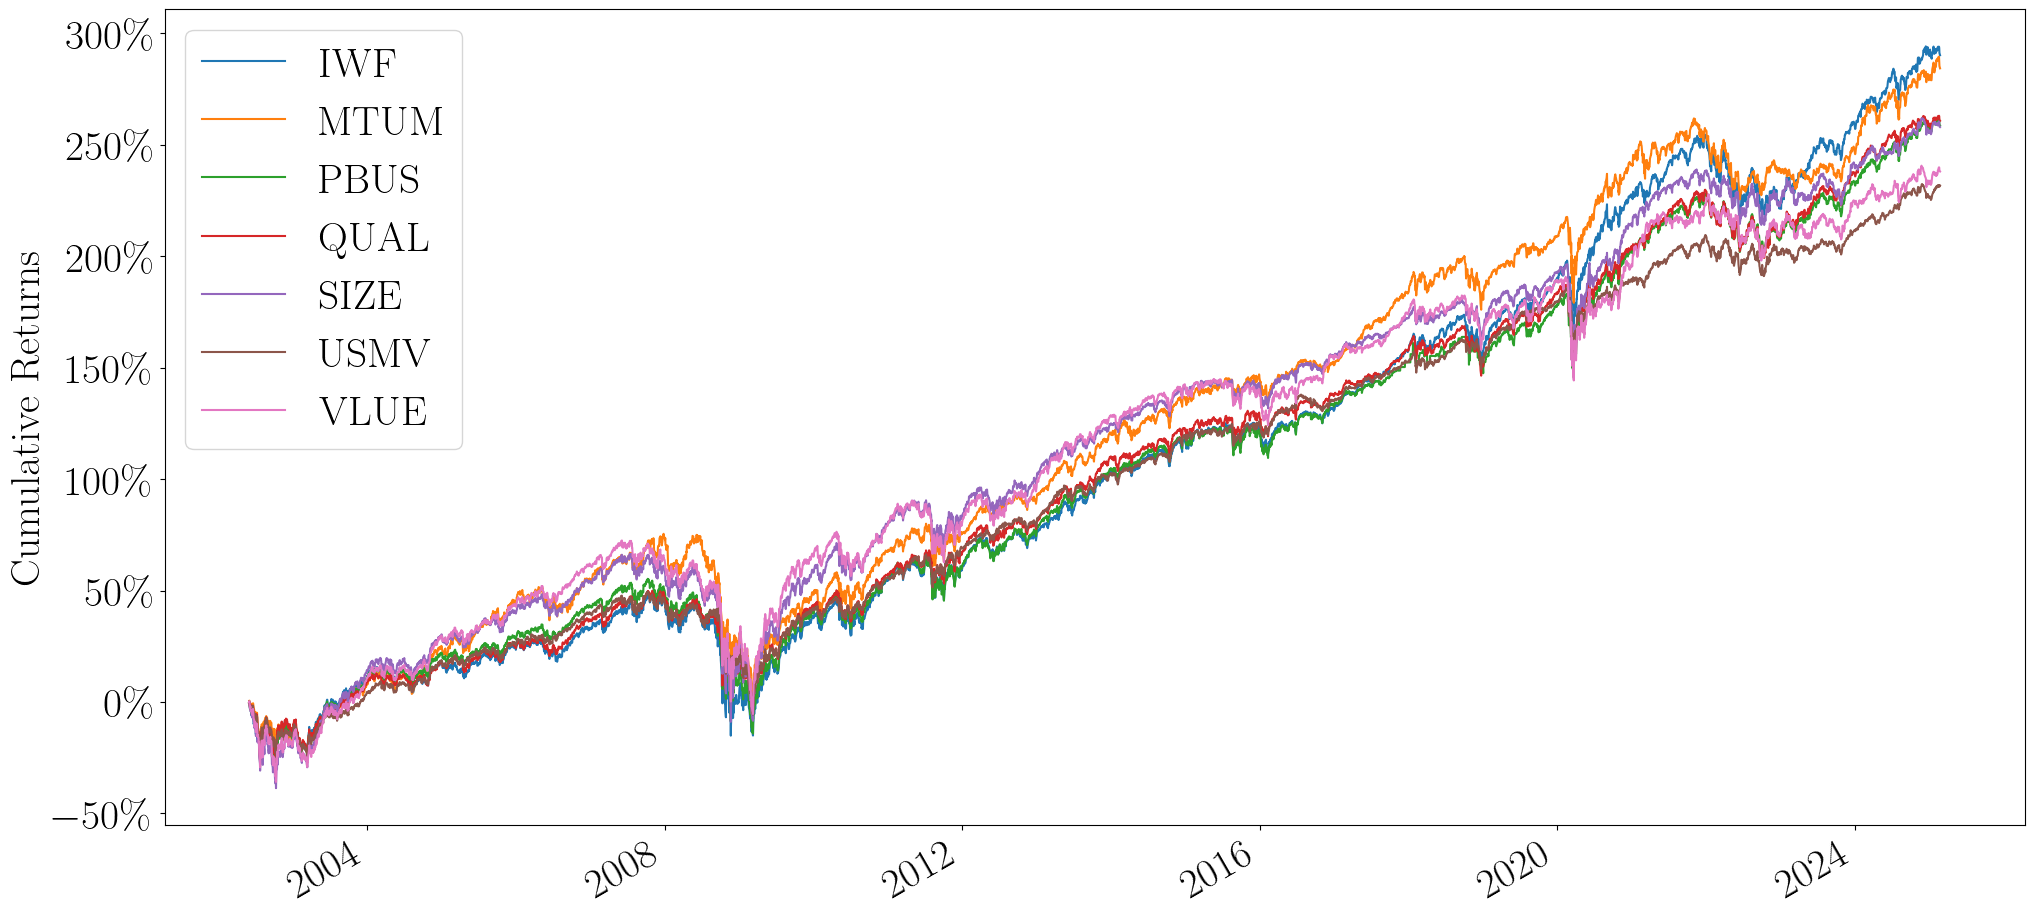

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import jumpmodels.utils
from jumpmodels.sparse_jump import SparseJumpModel  # use the sparse model
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\index_data"
file_path = os.path.join(directory, "full_returns.csv")

# Load the full returns dataset
full_returns = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Remove NaN rows (since markets were closed)
full_returns = full_returns.dropna()

# Select a target return series for financial anchoring (e.g., first factor)
ret_ser = full_returns.iloc[:, 0]  # First column as reference return series

# Compute cumulative returns
cumulative_returns = (1 + full_returns).cumprod()

# Plot cumulative returns
plot_cumret(full_returns)
plt.show()


In [38]:
unexplained_nan_dates = nan_dates[~nan_dates.isin(us_market_holidays)]
print("Unexplained NaN dates:\n", unexplained_nan_dates)


Unexplained NaN dates:
 DatetimeIndex(['2004-06-11', '2007-01-02', '2012-10-29', '2012-10-30', '2018-12-05', '2025-01-09', '2025-02-25'], dtype='datetime64[ns]', name='Date', freq=None)


In [6]:
# -------------------------
# Preprocessing
# -------------------------
# Clip the data within 3 standard deviations to mitigate the impact of outliers
clipper = DataClipperStd(mul=3.)
full_returns_clipped = clipper.fit_transform(full_returns)

# Standardize the clipped data (zero mean and unit variance)
scaler = StandardScalerPD()
full_returns_processed = scaler.fit_transform(full_returns_clipped)

Predicted states (in-sample):
Date
2002-05-30    0
2002-05-31    0
2002-06-03    0
2002-06-04    0
2002-06-05    0
             ..
2025-02-18    0
2025-02-19    0
2025-02-20    0
2025-02-21    0
2025-02-24    0
Length: 5722, dtype: int64
SJM Feature Weights:
IWF     0.531442
MTUM    0.230322
PBUS    0.601402
QUAL    0.643334
SIZE    0.649523
USMV    0.742446
VLUE    0.604434
dtype: float64


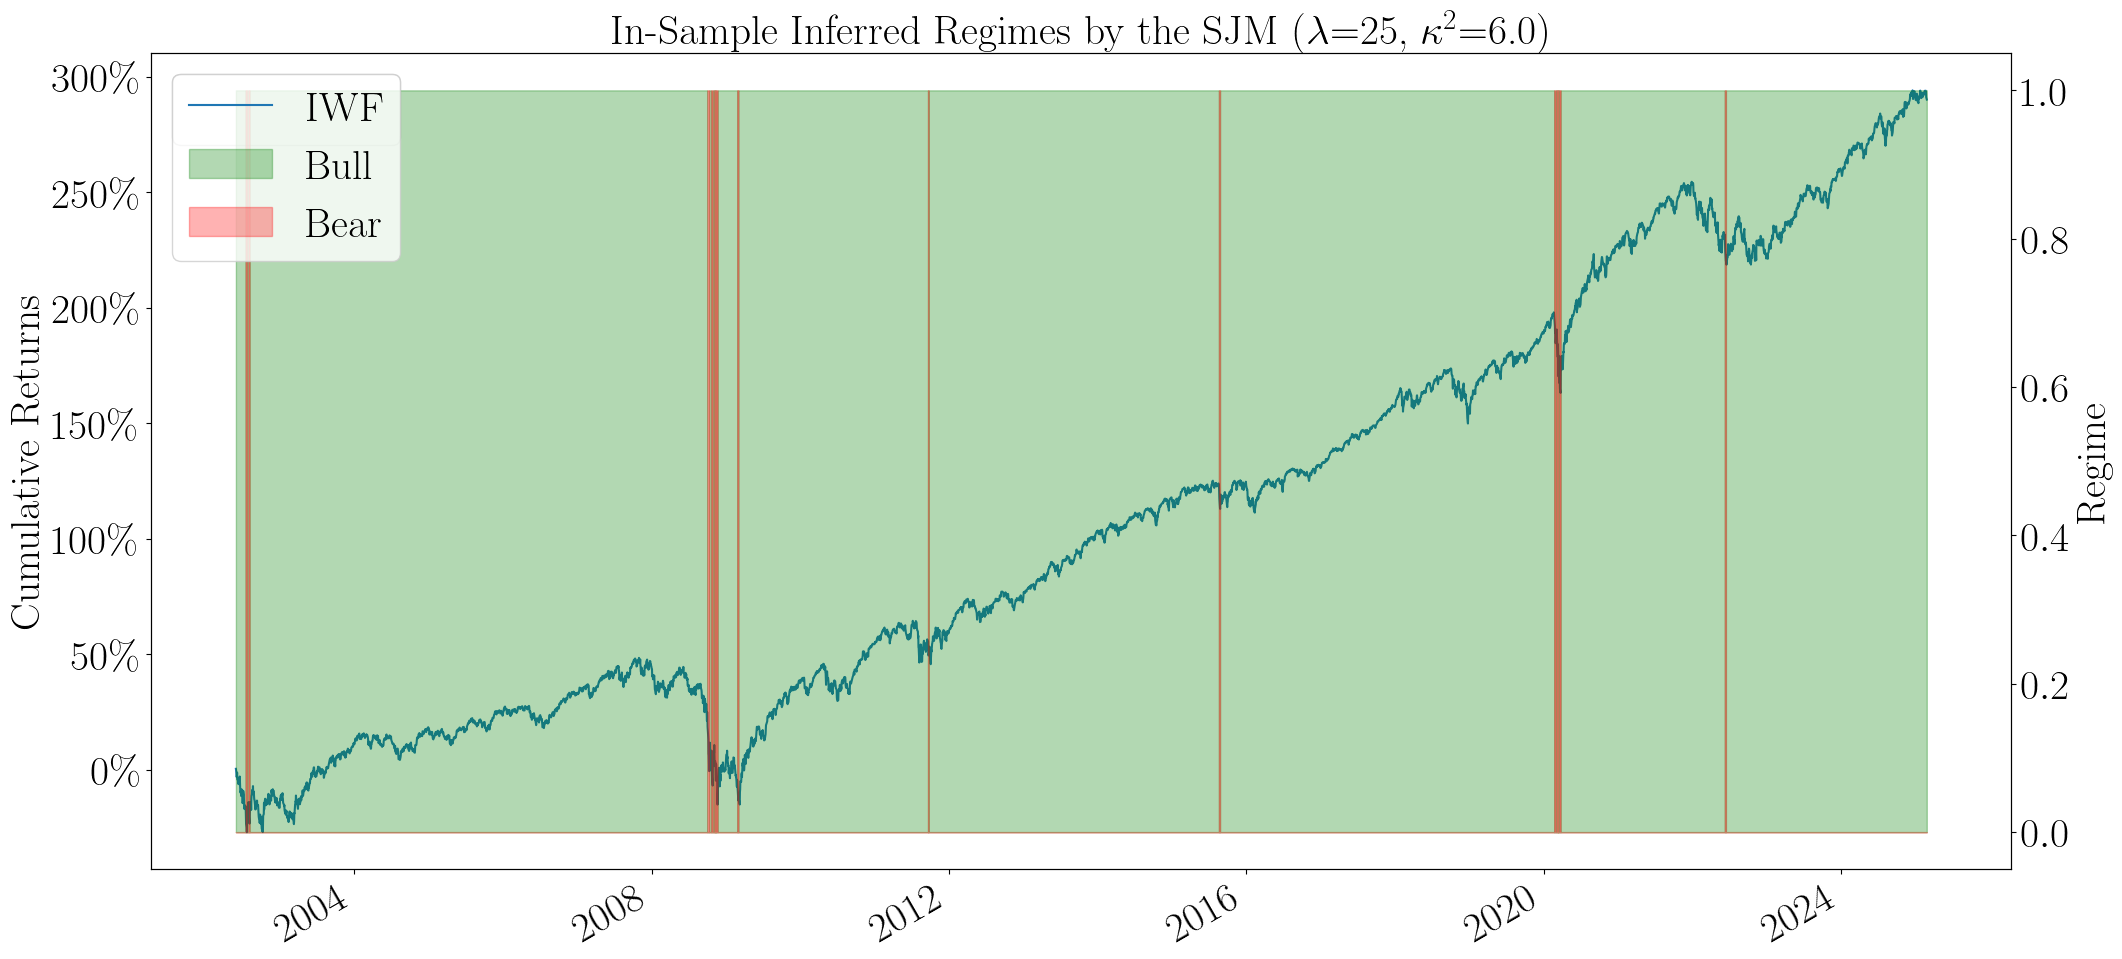

In [10]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------
max_feats = 6.        # Effective number of features, corresponding to kappa^2
jump_penalty = 25    # Jump penalty (similar in magnitude to the non-sparse model)

# Initialize the SparseJumpModel with 2 components (states)
model = SparseJumpModel(n_components=2, max_feats=max_feats, jump_penalty=jump_penalty, cont=False)

# Fit the model on the preprocessed data, using ret_ser for financial anchoring
model.fit(full_returns_processed, ret_ser, sort_by="cumret")

# Predict the states on the in-sample data
predicted_states = model.predict(full_returns_processed)
print("Predicted states (in-sample):")
print(predicted_states)

# Print the feature weights (sparse weights)
print("SJM Feature Weights:")
print(model.feat_weights)

ax, ax2 = plot_regimes_and_cumret(predicted_states, ret_ser)
ax.set(title=f"In-Sample Inferred Regimes by the SJM ($\\lambda$={jump_penalty}, $\\kappa^2$={max_feats})")
plt.show()